#### Imports

In [1]:
from datasets import load_dataset
import torch
from transformers import AutoTokenizer
import time
from transformers import DistilBertTokenizer, DistilBertModel
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from hyperopt import hp
from scipy.stats import kruskal
from lib.similarity import CentroidSimilarity
from utils.hyper_parameters_tuning import model_hypopt
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.visualization import plot_hist
from sklearn.neighbors import KNeighborsClassifier
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova,FeatureSelectionDiversityPursuitKruskal
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from utils.visualization import bar_plot_scores
%load_ext autoreload
%autoreload 2

In [2]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))


GPU Available: False
Number of GPU Available: 0


In [3]:
models_dir = "c:/transformer_models/"
if os.path.isdir(models_dir) is not True:
    os.mkdir(models_dir)

## Load the dataset

#### IMDB dataset

In [3]:
imdb = load_dataset("imdb")

Found cached dataset imdb (C:/Users/rgolan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
# embed the sentences - take 500 negative samples and 500 positive samples. Note that in the IMDB set, the negative examples are in the first half of the dataset (0-12500)
# the positive examples are in the second half
num_sentences_to_embed = 1000
neg_examples_idx = list(np.random.randint(low=0,high=12500,size=num_sentences_to_embed//2))
pos_examples_idx = list(np.random.randint(low=12500,high=25000,size=num_sentences_to_embed//2))
examples_to_embed_idx = neg_examples_idx + pos_examples_idx

In [5]:
train_sentences = [imdb['train'][int(i)]['text'] for i in examples_to_embed_idx]
train_labels = [imdb['train'][int(i)]['label'] for i in examples_to_embed_idx]
print(f"there are {len(train_sentences)} sentences in the training set")

there are 1000 sentences in the training set


#### AG-News dataset

In [4]:
ag_news_ds = load_dataset("ag_news")

Found cached dataset ag_news (C:/Users/rgolan/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
num_sentences_to_embed = 2000
all_labels = np.array([ag_news_ds['train'][int(i)]['label'] for i in range(len(ag_news_ds['train']))])
all_idx = np.arange(len(ag_news_ds['train']))
train_idx, test_idx, train_labels, test_labels = train_test_split(all_idx, all_labels, train_size=num_sentences_to_embed, stratify=all_labels)

In [6]:
train_sentences = [ag_news_ds['train'][int(train_idx[i])]['text'] for i in range(train_idx.shape[0])]

In [7]:
i = 100
print(train_sentences[i], train_labels[i])

US Women Wrap Up Softball Gold The US women #39;s softball team has finished a dominating performance at the Olympics by capturing the gold medal. The Americans had little trouble with Australia in the final Monday, cruising to a 5-1 victory. 1


## Get embeddings

#### BERT embeddings

In [8]:
# initialize a tokenizer
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir=models_dir)

In [9]:
from transformers import BertModel
bert_model = BertModel.from_pretrained("bert-base-uncased", cache_dir=models_dir)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
embed_dim = bert_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")
bert_model.config.output_hidden_states = True

embedding dimension = 768


In [11]:
bert_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = bert_tokenizer(train_sentences[i], padding=True, truncation=True, max_length=256, return_tensors="pt")
    with torch.no_grad():
        output = bert_model(**input)
    # as the sentence embedding we're taking the hidden state corresponding to the [CLS] token
    bert_embeddings[i,:] = output.last_hidden_state[:,0,:].numpy()
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


processed 101 sentences
so far, 8.5152 seconds passed 


processed 201 sentences
so far, 16.9043 seconds passed 


processed 301 sentences
so far, 25.6757 seconds passed 


processed 401 sentences
so far, 34.2587 seconds passed 


processed 501 sentences
so far, 43.4015 seconds passed 


processed 601 sentences
so far, 54.7391 seconds passed 


processed 701 sentences
so far, 67.1069 seconds passed 


processed 801 sentences
so far, 76.1254 seconds passed 


processed 901 sentences
so far, 84.9511 seconds passed 


processed 1001 sentences
so far, 93.4929 seconds passed 


processed 1101 sentences
so far, 102.3430 seconds passed 


processed 1201 sentences
so far, 111.2858 seconds passed 


processed 1301 sentences
so far, 120.5906 seconds passed 


processed 1401 sentences
so far, 129.0649 seconds passed 


processed 1501 sentences
so far, 137.3998 seconds passed 


processed 1601 sentences
so far, 146.6241 seconds passed 


processed 1701 sentences
so far, 156.6964 seconds passed 




In [12]:
print(f"bert embeddings shape = {bert_embeddings.shape}")

bert embeddings shape = (2000, 768)


#### GPT2 embeddings

In [12]:
from transformers import AutoTokenizer, GPT2Model
gpt2_tokenizer = AutoTokenizer.from_pretrained("gpt2", cache_dir=models_dir)
gpt2_model = GPT2Model.from_pretrained("gpt2", cache_dir=models_dir)

'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001FFA86A9A80>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/tokenizer_config.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001FFA86A8790>, 'Connection to huggingface.co timed out. (connect timeout=10)'))' thrown while requesting HEAD https://huggingface.co/gpt2/resolve/main/config.json
'HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /gpt2/resolve/main/tokenizer_config.json (Caused by ConnectTimeoutError(<urllib3.connection.HTTPSConnection object at 0x000001FFAA827490>, 'Connection to huggingface.co

In [13]:
embed_dim = gpt2_model.config.n_embd
print(f"embedding dimension = {embed_dim}")
gpt2_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = gpt2_tokenizer(train_sentences[i], truncation=True, max_length=256,return_tensors="pt")
    with torch.no_grad():
        output = gpt2_model(**input)
    # with GPT2 embeddings, we take the mean of the hidden states of all tokens
    gpt2_embeddings[i,:] = output.last_hidden_state[:,:,:].numpy().mean(axis=1)
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


embedding dimension = 768
processed 101 sentences
so far, 14.3031 seconds passed 


processed 201 sentences
so far, 30.4976 seconds passed 


processed 301 sentences
so far, 45.5717 seconds passed 


processed 401 sentences
so far, 61.4178 seconds passed 


processed 501 sentences
so far, 76.9001 seconds passed 


processed 601 sentences
so far, 92.2894 seconds passed 


processed 701 sentences
so far, 107.0138 seconds passed 


processed 801 sentences
so far, 121.9904 seconds passed 


processed 901 sentences
so far, 135.9049 seconds passed 


processed 1001 sentences
so far, 150.2268 seconds passed 


processed 1101 sentences
so far, 163.6525 seconds passed 


processed 1201 sentences
so far, 178.1675 seconds passed 


processed 1301 sentences
so far, 192.6098 seconds passed 


processed 1401 sentences
so far, 207.3017 seconds passed 


processed 1501 sentences
so far, 223.1118 seconds passed 


processed 1601 sentences
so far, 238.6901 seconds passed 


processed 1701 sentences
so f

#### XLNet embeddings

In [13]:
from transformers import XLNetModel

xlnet_tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased", cache_dir=models_dir)
xlnet_model = XLNetModel.from_pretrained("xlnet-base-cased", cache_dir=models_dir)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetModel: ['lm_loss.bias', 'lm_loss.weight']
- This IS expected if you are initializing XLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
embed_dim = xlnet_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")

embedding dimension = 768


In [15]:
xlnet_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = xlnet_tokenizer(train_sentences[i], truncation=True, max_length=256,return_tensors="pt")
    with torch.no_grad():
        output = xlnet_model(**input)
    xlnet_embeddings[i,:] = output.last_hidden_state[:,-1,:].numpy()
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")

processed 101 sentences
so far, 16.9354 seconds passed 


processed 201 sentences
so far, 30.9069 seconds passed 


processed 301 sentences
so far, 47.3327 seconds passed 


processed 401 sentences
so far, 61.6225 seconds passed 


processed 501 sentences
so far, 74.8898 seconds passed 


processed 601 sentences
so far, 90.1022 seconds passed 


processed 701 sentences
so far, 106.5749 seconds passed 


processed 801 sentences
so far, 123.4367 seconds passed 


processed 901 sentences
so far, 139.2724 seconds passed 


processed 1001 sentences
so far, 155.3009 seconds passed 


processed 1101 sentences
so far, 170.9008 seconds passed 


processed 1201 sentences
so far, 188.2460 seconds passed 


processed 1301 sentences
so far, 207.7570 seconds passed 


processed 1401 sentences
so far, 228.2706 seconds passed 


processed 1501 sentences
so far, 248.5855 seconds passed 


processed 1601 sentences
so far, 267.5698 seconds passed 


processed 1701 sentences
so far, 286.9463 seconds passe

#### BART embeddings

In [16]:
from transformers import AutoTokenizer, BartModel

bart_tokenizer = AutoTokenizer.from_pretrained("facebook/bart-base", cache_dir=models_dir)
bart_model = BartModel.from_pretrained("facebook/bart-base", cache_dir=models_dir)
embed_dim = bart_model.config.hidden_size
print(f"embedding dimension = {embed_dim}")

embedding dimension = 768


In [17]:
bart_embeddings = np.empty((num_sentences_to_embed,embed_dim))
tic = time.perf_counter()
for i in range(len(train_sentences)):
    input = bart_tokenizer(train_sentences[i], truncation=True, max_length=256,return_tensors="pt")
    with torch.no_grad():
        output = bart_model(**input)
    bart_embeddings[i,:] = output.last_hidden_state[:,:,:].numpy().mean(axis=1)
    if (i%100 == 0) and (i != 0):
        toc = time.perf_counter()
        print(f"processed {(i+1)} sentences")
        print(f"so far, {toc - tic:0.4f} seconds passed \n\n")


processed 101 sentences
so far, 11.8313 seconds passed 


processed 201 sentences
so far, 27.6402 seconds passed 


processed 301 sentences
so far, 43.9269 seconds passed 


processed 401 sentences
so far, 60.0633 seconds passed 


processed 501 sentences
so far, 77.9143 seconds passed 


processed 601 sentences
so far, 94.7392 seconds passed 


processed 701 sentences
so far, 112.7276 seconds passed 


processed 801 sentences
so far, 128.2996 seconds passed 


processed 901 sentences
so far, 145.0494 seconds passed 


processed 1001 sentences
so far, 161.3746 seconds passed 


processed 1101 sentences
so far, 180.6383 seconds passed 


processed 1201 sentences
so far, 200.4213 seconds passed 


processed 1301 sentences
so far, 216.4198 seconds passed 


processed 1401 sentences
so far, 231.7149 seconds passed 


processed 1501 sentences
so far, 247.3414 seconds passed 


processed 1601 sentences
so far, 263.6830 seconds passed 


processed 1701 sentences
so far, 281.0700 seconds passe

## Classification of embedded text

In [18]:
embed_list = [bart_embeddings,bert_embeddings,xlnet_embeddings]
X = np.concatenate(embed_list,axis=1)
print(f"X shape = {X.shape}")

X shape = (2000, 2304)


In [19]:
y = np.array(train_labels)

In [20]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
# tune a lasso classifier
lasso_search_space = {'C' : hp.uniform('C',0.001,10),
                          'penalty' : 'l1',
                          'solver' : 'liblinear'}
hyper_opt = model_hypopt(model=LogisticRegression, param_space=lasso_search_space, X_train=X, y_train=y, iterations=50)
lasso_best_params = hyper_opt.run()
print(f"lasso best_params = {lasso_best_params}")
# tune a lasso
hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=X, y_train=y, iterations=50)
svm_best_params = hyper_opt.run()
print(f"\n\n svm best_params = {svm_best_params}")



100%|██████████| 50/50 [07:18<00:00,  8.78s/trial, best loss: -0.891]             
lasso best_params = {'C': 0.08405828153472236, 'penalty': 'l1', 'solver': 'liblinear'}
100%|██████████| 50/50 [11:59<00:00, 14.40s/trial, best loss: -0.8995]            


 svm best_params = {'C': 5.741470836187142, 'degree': 5, 'kernel': 'rbf'}


Measuring accuracy with 4 classes,  5 training examples per class
---------------------------------------------------------------
classifier cs_cls, mean accuracy is 0.4416060606060606, std accuracy is 0.03963959793844997
classifier cs_fs_dp, mean accuracy is 0.6951818181818183, std accuracy is 0.09186812934010445
classifier cs_fs_ova, mean accuracy is 0.6298484848484849, std accuracy is 0.14390732408999263
classifier svm, mean accuracy is 0.5765252525252526, std accuracy is 0.06253750960945142
classifier lasso, mean accuracy is 0.297020202020202, std accuracy is 0.034971565694165256
classifier cs_cls, mean num features is 2304.0, std is 0.0
classifier cs_fs_dp, mean num features is 455.42, std is 7.581793982956804
classifier cs_fs_ova, mean num features is 1167.76, std is 95.10448149272462
classifier svm, mean num features is 2304.0, std is 0.0
classifier lasso, mean num features is 3.5, std is 0.8306623862918074




Measuring accuracy with 4 classes,  10 training examples per class
-

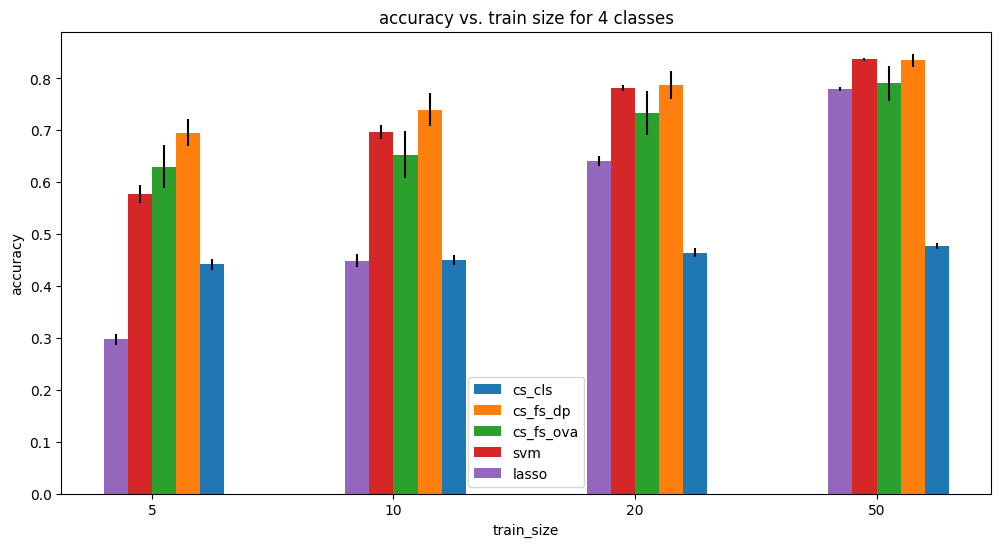

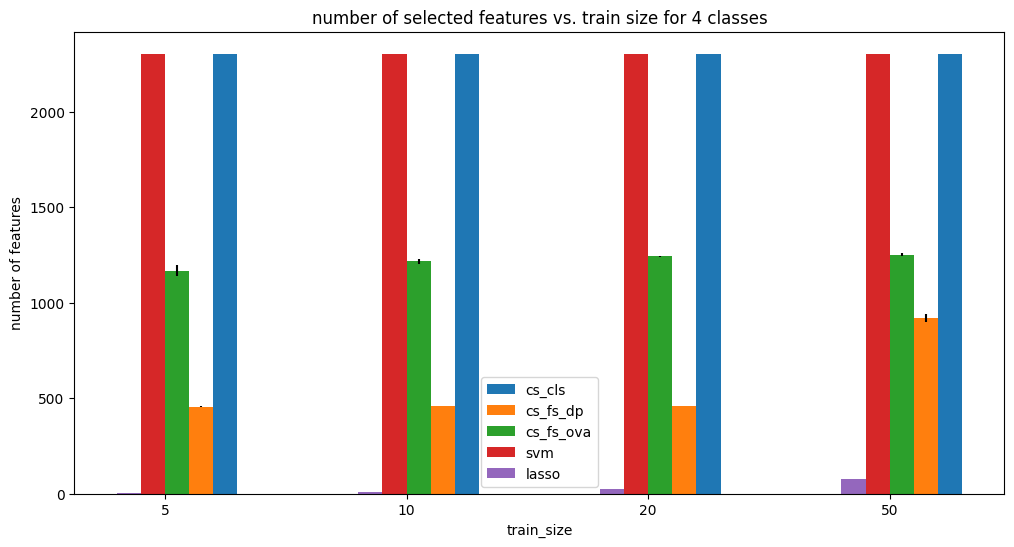

In [21]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova
gamma = 0.2
train_sizes = [5,10,20,50]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(CentroidSimilarity(), dp_fs)
cs_fs_ova = ClassifierFeatureSelection(CentroidSimilarity(), ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**svm_best_params)
lasso_cls = LogisticRegression(**lasso_best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, svm_cls, lasso_cls]
bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'svm', 'lasso']
num_experiments = 50
# define possible sizes for the train set (number of train examples per class)
num_classes = 4
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    print(f"Measuring accuracy with {num_classes} classes,  {train_sizes[i]} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_sizes[i]*num_classes, stratify=y)
        accuracies[:-1,i,j], num_features[:-1,i,j] = multiple_classifiers_fit_predict(classifiers=classifiers[:-1],
                                                                                              X_train=X_train,
                                                                                              y_train=y_train,
                                                                                              X_test=X_test,
                                                                                              y_test=y_test)
        lasso_cls.fit(X_train, y_train)
        accuracies[-1,i,j] = lasso_cls.score(X_test, y_test)
        #print(lasso_cls.coef_.shape)
        lasso_features = []
        for v in range(lasso_cls.coef_.shape[0]):
            lasso_features.extend(list(np.flatnonzero(lasso_cls.coef_[v,:])))
        lasso_features = set(lasso_features)
        lasso_num_coeff = len(lasso_features)
        #print(f"lasso_num_coeff = {lasso_num_coeff}")
        num_features[-1,i,j] = lasso_num_coeff
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean accuracy is {np.mean(accuracies[l,i,:])}, std accuracy is {np.std(accuracies[l,i,:])}")
    for l in range(len(classifiers)):
        print(f"classifier {bar_labels[l]}, mean num features is {np.mean(num_features[l,i,:])}, std is {np.std(num_features[l,i,:])}")
    print("\n\n\n")

bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes',
                err=2*np.std(accuracies,axis=2)/np.sqrt(accuracies.shape[2]))

bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes',
                err=2*np.std(num_features,axis=2)/np.sqrt(num_features.shape[2]))